# RandAugment for Image Classification for Improved Robustness


Data augmentation is a very useful technique that can help to improve the translational
invariance of convolutional neural networks (CNN). RandAugment is a stochastic data
augmentation routine for vision data and was proposed in
[RandAugment: Practical automated data augmentation with a reduced search space](https://arxiv.org/abs/1909.13719).
It is composed of strong augmentation transforms like color jitters, Gaussian blurs,
saturations, etc. along with more traditional augmentation transforms such as
random crops.

These parameters are tuned for a given dataset and a network architecture. The authors of
RandAugment also provide pseudocode of RandAugment in the original paper (Figure 2).

Recently, it has been a key component of works like
[Noisy Student Training](https://arxiv.org/abs/1911.04252) and
[Unsupervised Data Augmentation for Consistency Training](https://arxiv.org/abs/1904.12848).
It has been also central to the
success of [EfficientNets](https://arxiv.org/abs/1905.11946).


```python
pip install keras-cv
```

In [2]:
pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 46.2 MB/s eta 0:00:00


## Imports & setup

In [3]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import keras_cv
from keras import ops
from keras import layers
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
keras.utils.set_random_seed(42)

## Load the CIFAR10 dataset

For this example, we will be using the
[CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
print(f"Total training examples: {len(x_train)}")
print(f"Total test examples: {len(x_test)}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Total training examples: 50000
Total test examples: 10000


## Define hyperparameters

In [6]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 128
EPOCHS = 1
IMAGE_SIZE = 72

## Initialize `RandAugment` object

Now, we will initialize a `RandAugment` object from the `imgaug.augmenters` module with
the parameters suggested by the RandAugment authors.

In [7]:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255), augmentations_per_image=3, magnitude=0.8
)


## Create TensorFlow `Dataset` objects

In [8]:
train_ds_rand = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )
    .map(
        lambda x, y: (rand_augment(tf.cast(x, tf.uint8)), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

test_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .map(
        lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
        num_parallel_calls=AUTO,
    )
    .prefetch(AUTO)
)

For comparison purposes, let's also define a simple augmentation pipeline consisting of
random flips, random rotations, and random zoomings.

In [9]:
simple_aug = keras.Sequential(
    [
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ]
)

# Now, map the augmentation pipeline to our training dataset
train_ds_simple = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
    .map(lambda x, y: (simple_aug(x), y), num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

## Visualize the dataset augmented with RandAugment

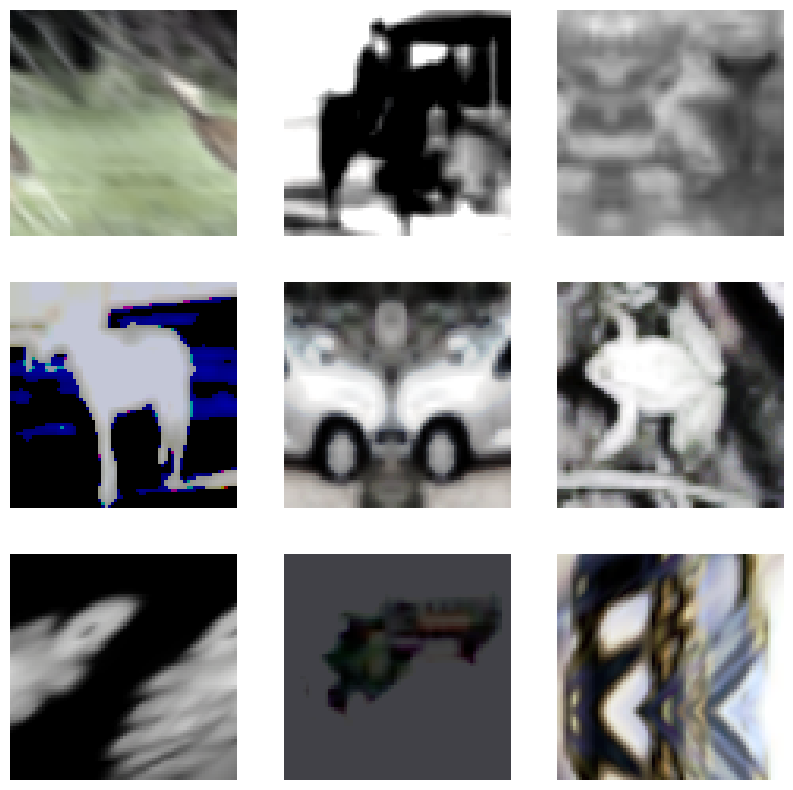

In [10]:
sample_images, _ = next(iter(train_ds_rand))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

You are encouraged to run the above code block a couple of times to see different
variations.

## Visualize the dataset augmented with `simple_aug`

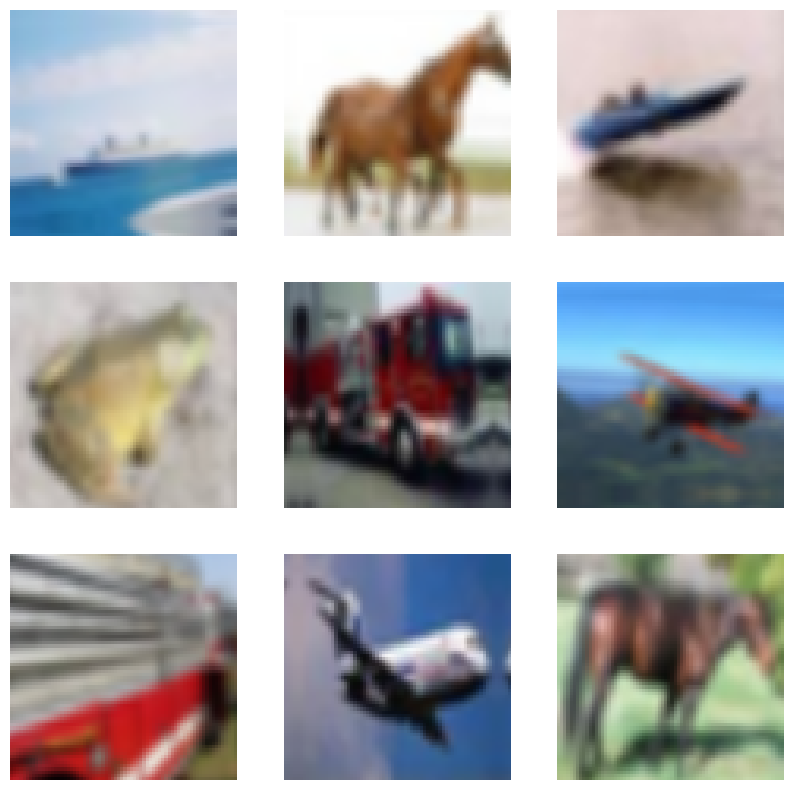

In [11]:
sample_images, _ = next(iter(train_ds_simple))
plt.figure(figsize=(10, 10))
for i, image in enumerate(sample_images[:9]):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("int"))
    plt.axis("off")

## Define a model building utility function

Now, we define a CNN model that is based on the
[ResNet50V2 architecture](https://arxiv.org/abs/1603.05027). Also,
notice that the network already has a rescaling layer inside it. This eliminates the need
to do any separate preprocessing on our dataset and is specifically very useful for
deployment purposes.

In [12]:

def get_training_model():
    resnet50_v2 = keras.applications.ResNet50V2(
        weights=None,
        include_top=True,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
        classes=10,
    )
    model = keras.Sequential(
        [
            layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
            layers.Rescaling(scale=1.0 / 127.5, offset=-1),
            resnet50_v2,
        ]
    )
    return model


get_training_model().summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 72, 72, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 10)                  │      23,585,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,585,290 (89.97 MB)

 Trainable params: 23,539,850 (89.80 MB)

 Non-trainable params: 45,440 (177.50 KB)

We will train this network on two different versions of our dataset:

* One augmented with RandAugment.
* Another one augmented with `simple_aug`.

Since RandAugment is known to enhance the robustness of models to common perturbations
and corruptions, we will also evaluate our models on the CIFAR-10-C dataset, proposed in
[Benchmarking Neural Network Robustness to Common Corruptions and Perturbations](https://arxiv.org/abs/1903.12261)
by Hendrycks et al. The CIFAR-10-C dataset
consists of 19 different image corruptions and perturbations (for example speckle noise,
fog, Gaussian blur, etc.) that too at varying severity levels. For this example we will
be using the following configuration:
[`cifar10_corrupted/saturate_5`](https://www.tensorflow.org/datasets/catalog/cifar10_corrupted#cifar10_corruptedsaturate_5).
The images from this configuration look like so:

![](https://storage.googleapis.com/tfds-data/visualization/fig/cifar10_corrupted-saturate_5-1.0.0.png)

In the interest of reproducibility, we serialize the initial random weights of our shallow
network.

In [13]:
initial_model = get_training_model()
initial_model.save_weights("initial.weights.h5")

## Train model with RandAugment

In [14]:
rand_aug_model = get_training_model()
rand_aug_model.load_weights("initial.weights.h5")
rand_aug_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
rand_aug_model.fit(train_ds_rand, validation_data=test_ds, epochs=EPOCHS)
_, test_acc = rand_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

391/391 ━━━━━━━━━━━━━━━━━━━━ 357s 760ms/step - accuracy: 0.1728 - loss: 2.3304 - val_accuracy: 0.3221 - val_loss: 1.8012
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3265 - loss: 1.8050
Test accuracy: 32.21%


## Train model with `simple_aug`

In [15]:
simple_aug_model = get_training_model()
simple_aug_model.load_weights("initial.weights.h5")
simple_aug_model.compile(
    loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
simple_aug_model.fit(train_ds_simple, validation_data=test_ds, epochs=EPOCHS)
_, test_acc = simple_aug_model.evaluate(test_ds)
print("Test accuracy: {:.2f}%".format(test_acc * 100))

391/391 ━━━━━━━━━━━━━━━━━━━━ 139s 249ms/step - accuracy: 0.4007 - loss: 1.6951 - val_accuracy: 0.4897 - val_loss: 1.5746
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.4932 - loss: 1.5675
Test accuracy: 48.97%


## Load the CIFAR-10-C dataset and evaluate performance

In [16]:
# Load and prepare the CIFAR-10-C dataset
# (If it's not already downloaded, it takes ~10 minutes of time to download)
cifar_10_c = tfds.load("cifar10_corrupted/saturate_5", split="test", as_supervised=True)
cifar_10_c = cifar_10_c.batch(BATCH_SIZE).map(
    lambda x, y: (tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE)), y),
    num_parallel_calls=AUTO,
)

# Evaluate `rand_aug_model`
_, test_acc = rand_aug_model.evaluate(cifar_10_c, verbose=0)
print(
    "Accuracy with RandAugment on CIFAR-10-C (saturate_5): {:.2f}%".format(
        test_acc * 100
    )
)

# Evaluate `simple_aug_model`
_, test_acc = simple_aug_model.evaluate(cifar_10_c, verbose=0)
print(
    "Accuracy with simple_aug on CIFAR-10-C (saturate_5): {:.2f}%".format(
        test_acc * 100
    )
)

Dataset cifar10_corrupted downloaded and prepared to /root/tensorflow_datasets/cifar10_corrupted/saturate_5/1.0.0. Subsequent calls will reuse this data.
Accuracy with RandAugment on CIFAR-10-C (saturate_5): 28.33%
Accuracy with simple_aug on CIFAR-10-C (saturate_5): 37.94%


For the purpose of this example, we trained the models for only a single epoch. On the
CIFAR-10-C dataset, the model with RandAugment can perform better with a higher accuracy
(for example, 76.64% in one experiment) compared with the model trained with `simple_aug`
(e.g., 64.80%). RandAugment can also help stabilize the training.

In the notebook, you may notice that, at the expense of increased training time with RandAugment,
we are able to carve out far better performance on the CIFAR-10-C dataset. You can
experiment on the other corruption and perturbation settings that come with the
run the same CIFAR-10-C dataset and see if RandAugment helps.

You can also experiment with the different values of `n` and `m` in the `RandAugment`
object. In the [original paper](https://arxiv.org/abs/1909.13719), the authors show
the impact of the individual augmentation transforms for a particular task and a range of
ablation studies. You are welcome to check them out.

RandAugment has shown great progress in improving the robustness of deep models for
computer vision as shown in works like [Noisy Student Training](https://arxiv.org/abs/1911.04252) and
[FixMatch](https://arxiv.org/abs/2001.07685). This makes RandAugment quite a useful
recipe for training different vision models.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/randaugment)
and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/randaugment).